In [ ]:
# CAP 6619-002
# Movie Classifier
# Dr. Zhu
# Michael Cuomo

In [2]:
import os
import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import pathlib
import re
import csv
import random

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization


In [3]:
directory = os.fsencode("./data/genres")
movie_names = []
for file in os.listdir(directory):
    movie_names.append(os.fsdecode(file))

print(movie_names[:20])

['10_Things_I_Hate_About_You.txt', '12.txt', '127_Hours.txt', '12_and_Holding.txt', '12_Monkeys.txt', '12_Years_a_Slave.txt', '1492_Conquest_of_Paradise.txt', '15_Minutes.txt', '17_Again.txt', '187.txt', '2001_A_Space_Odyssey.txt', '2012.txt', '28_Days_Later.txt', '30_Minutes_or_Less.txt', '44_Inch_Chest.txt', '48_Hrs.txt', '50-50.txt', '500_Days_of_Summer.txt', '8MM.txt', '9.txt']


In [4]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])


In [21]:
def create_encoder(vocab_size = 50000):
    encoder = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
    dataset = tf.data.TextLineDataset(filenames = list(map(lambda x: f"./data/scripts/{x}", movie_names)))
    for line in dataset.take(5):
        print(line.numpy())
    encoder.adapt(dataset.batch(1024))
    return encoder

In [24]:
def writeEncoder(encoder, filename, vocab_size = 50000):
    with open(f"./data/vocabs/{filename}_{vocab_size}.txt", "w", encoding = 'utf-8') as f:
        wr = csv.writer(f)
        wr.writerow(encoder.get_vocabulary())
        

In [5]:
def get_existing_encoder(encoder_type = "", vocab_size = 50000):
    if vocab_size != 50000 and vocab_size != 10000 and vocab_size != 5000:
        raise ValueError("Vocab of that size does not exist")
    encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
    f = open(f"./data/vocabs/vocab{encoder_type}_{vocab_size}.txt", "r", errors = "ignore", encoding = "utf-8")
    vocab = f.read()
    f.close()

    encoder.set_vocabulary(vocab.split(","))
    return encoder

In [6]:
directory = os.fsencode("./data/genres")
movie_names = []
for file in os.listdir(directory):
    movie_names.append(os.fsdecode(file))

print(movie_names[:20])

['10_Things_I_Hate_About_You.txt', '12.txt', '127_Hours.txt', '12_and_Holding.txt', '12_Monkeys.txt', '12_Years_a_Slave.txt', '1492_Conquest_of_Paradise.txt', '15_Minutes.txt', '17_Again.txt', '187.txt', '2001_A_Space_Odyssey.txt', '2012.txt', '28_Days_Later.txt', '30_Minutes_or_Less.txt', '44_Inch_Chest.txt', '48_Hrs.txt', '50-50.txt', '500_Days_of_Summer.txt', '8MM.txt', '9.txt']


In [8]:
# for movie in movie_names:
#     with open(f".\\data\\scripts_old\\{movie}", 'r') as r, open(f'.\\data\\scripts\\{movie}', 'w', encoding = 'utf8') as o: 
#         for line in r: 
#             if line.strip(): 
#                 o.write(line.strip() +'\n') 

In [7]:
def createSuccinctOutputVectorModel(encoder = get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000)):
    model = tf.keras.models.Sequential()
    model.add(encoder)
    model.add(tf.keras.layers.Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, mask_zero = True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
    # model.add(tf.keras.layers.LSTM(1024, input = (1024, 17466)))

    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(27, activation='softmax'))
    return model


In [33]:
def succintGenerator(seed = 42, train_split = 0.75, is_train = True):
    # for movie in movie_names:
    #     s = open(f".\\data\\scripts\\{movie}", "r")
    #     script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    #     s.close()
    #     if is_train:
    #         script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    #     else:
    #         script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    #     k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    #     keywords = k.read().split(",")
    #     k.close()
    #     for line in script_lines:
    #         yield line, keywords
    movie = movie_names[0]
    s = open(f"./data/scripts/{movie}", "r")
    script_lines = random.Random(seed).shuffle(s.read().split("\n"))
    s.close()
    if is_train:
        script_lines = script_lines[:int(len(script_lines) * train_split) + 1]
    else:
        script_lines = script_lines[-(int(len(script_lines) * train_split) + 1):]
    k = open(f"./data/vectorized_keywords_succinct/{movie}", "r")
    keywords = k.read().split(",")
    k.close()
    for line in script_lines:
        yield line, keywords

In [8]:
def trainSuccintGenerator():
    # movie = movie_names[0]
    # s = open(f".\\data\\scripts\\{movie}", "r")
    # script_lines = s.read().split("\n")
    # s.close()
    # random.Random(42).shuffle(script_lines)
    # script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
    # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    # keywords = k.read().split(",")
    # k.close()
    # for line in script_lines:
    #     yield line, keywords
     for movie in movie_names:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(42).shuffle(script_lines)
        script_lines = script_lines[:int(len(script_lines) * 0.75) + 1]
        # genres = numpy.loadtxt(f"./data/vectorized_genres/{movie}", delimiter = ",")
        # for line in script_lines:
        #     yield line, genres
        g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        genres = g.read().split(",")
        g.close()
        for line in script_lines:
            yield line, tf.stack(genres)

In [9]:
def testSuccintGenerator():
    # movie = movie_names[0]
    # s = open(f".\\data\\scripts\\{movie}", "r")
    # script_lines = s.read().split("\n")
    # s.close()
    # random.Random(42).shuffle(script_lines)
    # script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
    # k = open(f".\\data\\vectorized_keywords_succinct\\{movie}", "r")
    # keywords = k.read().split(",")
    # k.close()
    # for line in script_lines:
    #     yield line, keywords
    for movie in movie_names:
        s = open(f"./data/scripts/{movie}", "r", errors = "ignore", encoding='utf-8')
        script_lines = s.read().split("\n")
        s.close()
        random.Random(42).shuffle(script_lines)
        script_lines = script_lines[-(int(len(script_lines) * 0.75) + 1):]
        # genres = numpy.loadtxt(f"./data/vectorized_genres/{movie}", delimiter = ",")
        # for line in script_lines:
        #     yield line, genres
        g = open(f"./data/vectorized_genres_succinct/{movie}", "r", errors = "ignore", encoding = 'utf8')
        genres = g.read().split(",")
        g.close()
        for line in script_lines:
            yield line, tf.stack(genres)

In [10]:
def getSuccinctTrainDataset():
    dataset = tf.data.Dataset.from_generator(trainSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (27,), dtype = tf.float32)))
    return dataset

In [11]:
def getSuccinctTestDataset():
    dataset = tf.data.Dataset.from_generator(testSuccintGenerator, output_signature = (
        tf.TensorSpec(shape = (), dtype = tf.string),
        tf.TensorSpec(shape = (27,), dtype = tf.float32)))
    return dataset

In [12]:
def parse_map(data, labels):
    return data, tf.stack(labels, axis=0)

In [43]:
tf.keras.backend.clear_session()

In [12]:
model = createSuccinctOutputVectorModel(get_existing_encoder(encoder_type = "_ubuntu", vocab_size = 10000))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=False)
train = getSuccinctTrainDataset()
test = getSuccinctTestDataset()

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


In [13]:
BATCH_SIZE = 64
train = train.batch(BATCH_SIZE)
test = test.batch(BATCH_SIZE)
history = model.fit(train, epochs = 10,
                    validation_data=test,
                    validation_steps=30)


Epoch 1/10
49758/49758 [==============================] - 3939s 79ms/step - loss: 240162.3281 - accuracy: 0.4209 - val_loss: 34830.9531 - val_accuracy: 1.0000
Epoch 2/10
49758/49758 [==============================] - 5033s 101ms/step - loss: 1439823.6250 - accuracy: 0.4180 - val_loss: 76074.1641 - val_accuracy: 1.0000
Epoch 3/10
49758/49758 [==============================] - 4959s 100ms/step - loss: 3928077.7500 - accuracy: 0.4202 - val_loss: 127019.0078 - val_accuracy: 1.0000
Epoch 4/10
49758/49758 [==============================] - 11469s 230ms/step - loss: 7845217.5000 - accuracy: 0.4184 - val_loss: 170090.9688 - val_accuracy: 1.0000
Epoch 5/10
49758/49758 [==============================] - 7480s 150ms/step - loss: 13262470.0000 - accuracy: 0.4164 - val_loss: 225496.0625 - val_accuracy: 1.0000
Epoch 6/10
49758/49758 [==============================] - 5503s 111ms/step - loss: 20135900.0000 - accuracy: 0.4166 - val_loss: 270520.3125 - val_accuracy: 1.0000
Epoch 7/10
49758/49758 [=====

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, None)              0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 27)                1755      
                                                                 
Total params: 716059 (2.73 MB)
Trainable params: 716059 

In [14]:
test_loss, test_acc = model.evaluate(test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


49758/49758 [==============================] - 1266s 25ms/step - loss: 71556944.0000 - accuracy: 0.3242
Test Loss: 71556944.0
Test Accuracy: 0.3241651654243469


(0.0, 68200008.85234375)

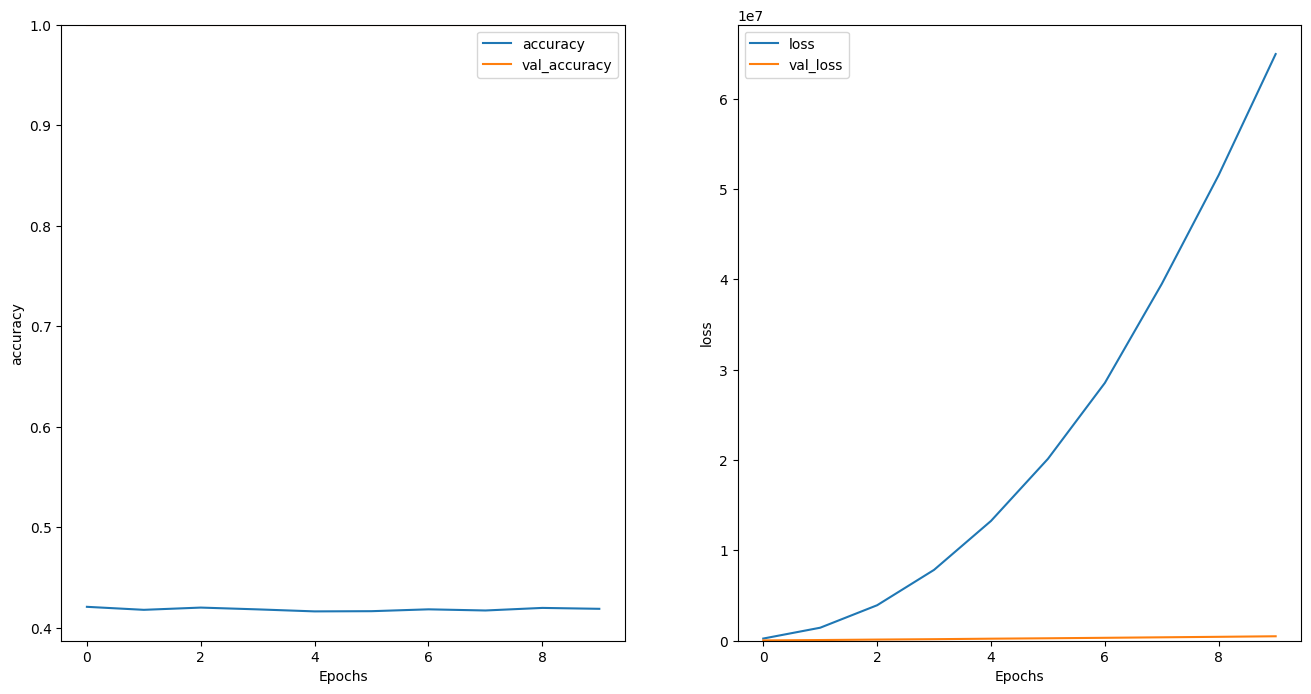

In [16]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
